Initial Shape: (541909, 8)

Missing values per column:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
Shape after dropping nulls: (406829, 8)
Shape after removing duplicates: (401604, 8)
Shape after removing anomalies: (392692, 8)


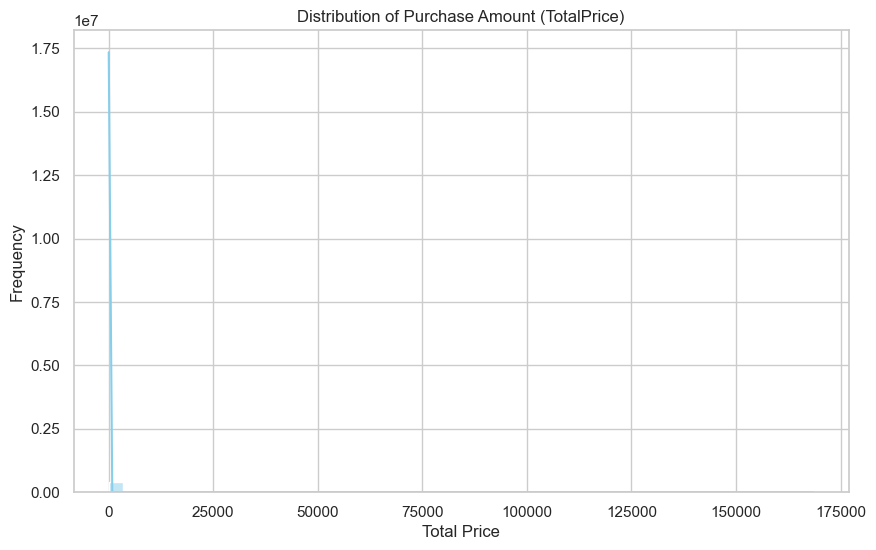

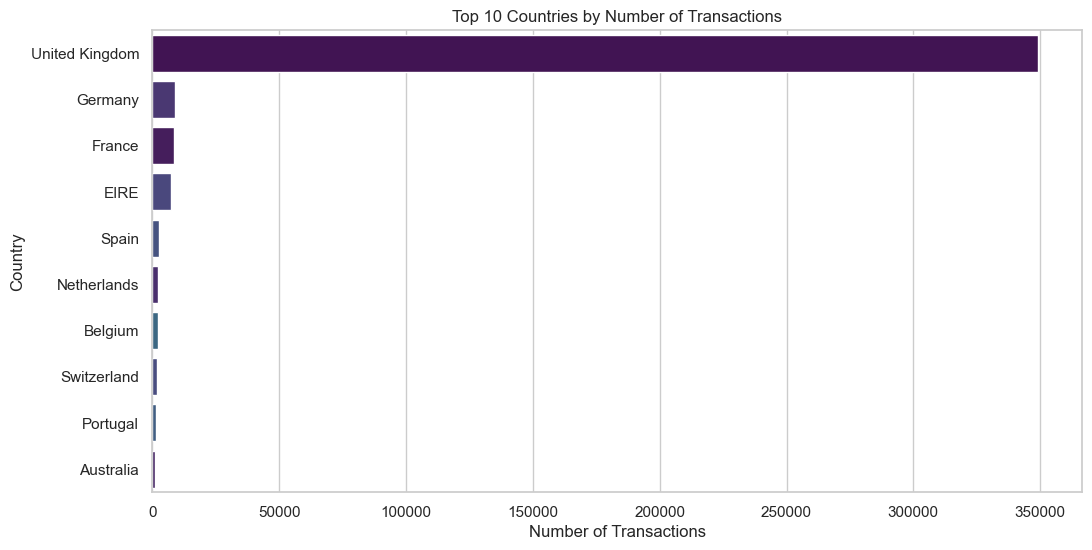

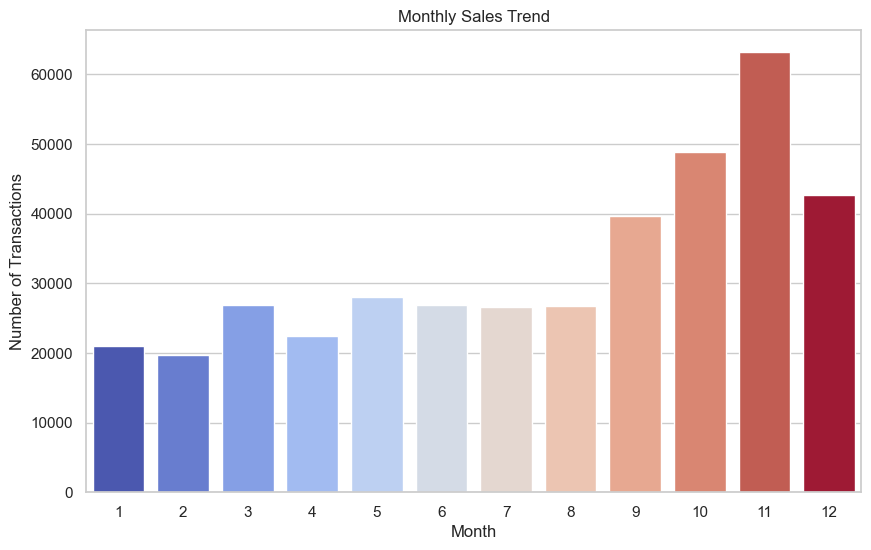

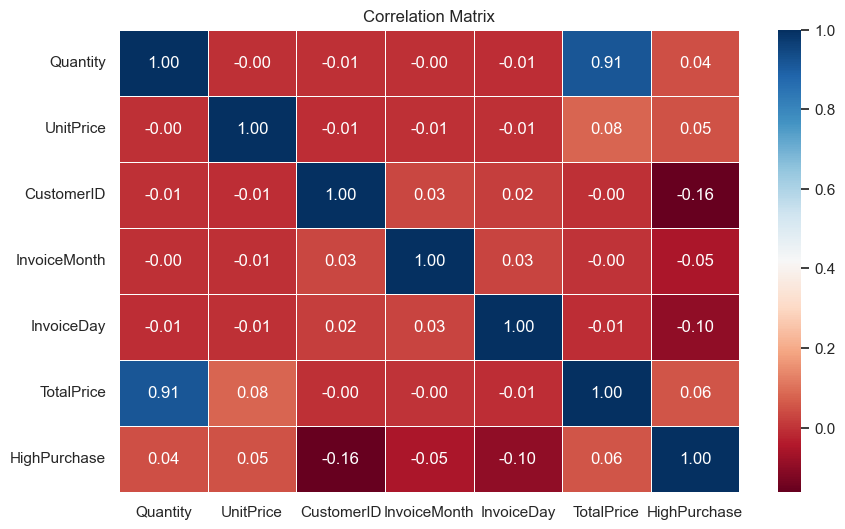

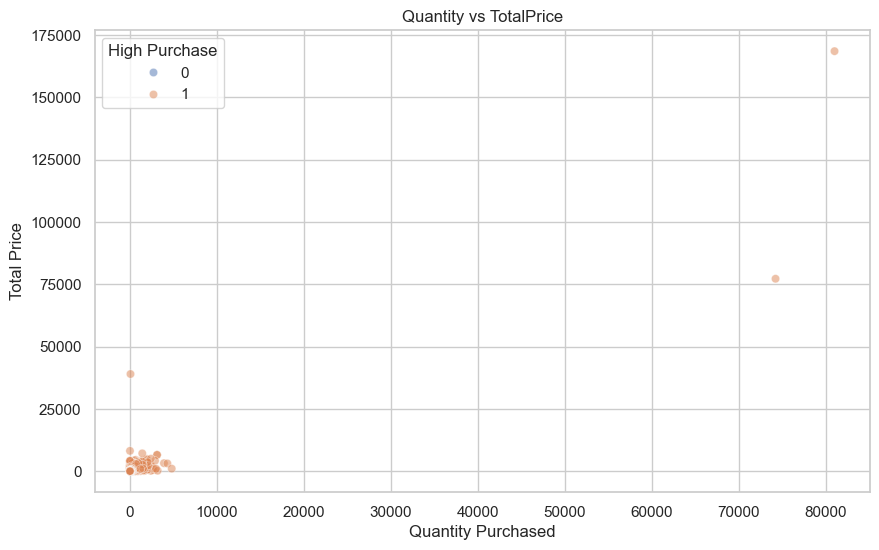


 � Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     59034
           1       1.00      1.00      1.00     58774

    accuracy                           1.00    117808
   macro avg       1.00      1.00      1.00    117808
weighted avg       1.00      1.00      1.00    117808

 Confusion Matrix:
 [[59034     0]
 [    0 58774]]
Accuracy Score: 1.0


In [27]:
# Step 1: Importing Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Optional: Display all columns in output
pd.set_option('display.max_columns', None)


#  Step 2: Loading the Dataset

df = pd.read_csv("data.csv")
print("Initial Shape:", df.shape)
df.head()


#  Step 3: Data Cleaning


# 1. Handle Missing Values
print("\nMissing values per column:\n", df.isnull().sum())
df.dropna(inplace=True)
print("Shape after dropping nulls:", df.shape)

# 2. Remove Duplicates
df.drop_duplicates(inplace=True)
print("Shape after removing duplicates:", df.shape)

# 3. Handle Anomalies (e.g., negative Quantity or UnitPrice) 
if 'Quantity' in df.columns:
    df = df[df['Quantity'] > 0]
if 'UnitPrice' in df.columns:
    df = df[df['UnitPrice'] > 0]
print("Shape after removing anomalies:", df.shape)

# 4. Convert Dates
if 'InvoiceDate' in df.columns:
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    df['InvoiceMonth'] = df['InvoiceDate'].dt.month
    df['InvoiceDay'] = df['InvoiceDate'].dt.dayofweek

# 5. Create a TotalPrice Column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# 6. Create a Target Variable: High Purchase (1) or Not (0)
threshold = df['TotalPrice'].median()
df['HighPurchase'] = (df['TotalPrice'] > threshold).astype(int)


# Step 4: Exploratory Data Analysis (EDA)

sns.set(style="whitegrid")

# 1. Distribution of Purchase Amount
plt.figure(figsize=(10, 6))
sns.histplot(df['TotalPrice'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Purchase Amount (TotalPrice)')
plt.xlabel('Total Price')
plt.ylabel('Frequency')
plt.show()

# 2. Number of Transactions by Country
plt.figure(figsize=(12, 6))
sns.countplot(y='Country', data=df, order=df['Country'].value_counts().index[:10], hue='Country', palette='viridis', legend=False)
plt.title('Top 10 Countries by Number of Transactions')
plt.xlabel('Number of Transactions')
plt.ylabel('Country')
plt.show()


# 3. Monthly Trend of Transactions
plt.figure(figsize=(10, 6))
sns.countplot(x='InvoiceMonth', data=df, hue='InvoiceMonth', palette='coolwarm', legend=False)
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.show()


# 4. Correlation Heatmap
plt.figure(figsize=(10, 6))
numeric_cols = df.select_dtypes(include='number')
corr = numeric_cols.corr()
sns.heatmap(corr, annot=True, cmap='RdBu', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# 5. Quantity vs. TotalPrice Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Quantity', y='TotalPrice', hue='HighPurchase', data=df, alpha=0.5)
plt.title('Quantity vs TotalPrice')
plt.xlabel('Quantity Purchased')
plt.ylabel('Total Price')
plt.legend(title='High Purchase')
plt.show()

# Step 5: Feature Engineering


# Drop non-useful or high-cardinality columns
drop_cols = ['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate']
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

# Encode categorical variables
le = LabelEncoder()
if 'Country' in df.columns:
    df['Country'] = le.fit_transform(df['Country'])
if 'CustomerID' in df.columns:
    df['CustomerID'] = le.fit_transform(df['CustomerID'].astype(str))  # Handle float IDs

# Step 6: Building Predictive Model (used random forest)

# Define Features and Target
X = df.drop(['HighPurchase'], axis=1)
y = df['HighPurchase']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = model.predict(X_test)
print("\n � Classification Report:\n", classification_report(y_test, y_pred))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
